#  TIME SERIES FORECASTING - Milk Manufactuer Revenue Estimates

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

#TIME SERIES
import statsmodels.api as sm
import statsmodels.tsa.api as smt 
#Imporing the api imports

#MATPLOTLIB
from scipy import stats, integrate
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [3]:
milk = pd.read_csv('sales_full_final.csv')
#milk.columns.values

In [4]:
milk_weekly = milk.groupby('cod_semana').mean()

## MANUFACTURER 2, HYPER/ SUPER- MARKET

### Data

In [5]:
#NO PROMOTIONS
milk2_mhnp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']==1) & (milk['dummy_Promo_descuento']!=1)]

no_promo_hyper = milk2_mhnp.groupby('cod_semana').mean()

In [6]:
#PROMOTIONS
milk2_mhp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']==1) & (milk['dummy_Promo_descuento']==1)]
promo_hyper = milk2_mhp.groupby('cod_semana').mean()

#Supermarket
#milk2_ms = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 #(milk['dummy_channel_supermarket']==1) & (milk['dummy_Promo_descuento']!=1)]
#w_milk2_ms = milk2_ms.groupby('cod_semana').mean()

#y = w_milk2_mh.ventas_valor #take the series

In [8]:
#SANITY CHECK
print('All Data Product Discounts', milk.dummy_Promo_descuento.mean())
print('Hyper Promo', promo_hyper.dummy_Promo_descuento.mean())
print('Hyper No Promo', no_promo_hyper.dummy_Promo_descuento.mean())

All Data Product Discounts 0.18276050526189655
Hyper Promo 1.0
Hyper No Promo 0.0


# HYPERMARKET - NO PROMO
## STEPWISE REGRESSION

In [122]:
import statsmodels.api as sm


X = no_promo_hyper.drop(['ventas_valor'], axis=1)
y = no_promo_hyper.ventas_valor


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Add  sales_value_by_sqmeter         with p-value 6.51134e-91
Add  sales_surface_sqmeters         with p-value 8.76468e-15
Add  addtv_present_CALCIUM          with p-value 2.29138e-16
Add  sgmnt_present_KIDS_<=_3_YEARS_OLD with p-value 2.29138e-16
Add  dummy_channel_hypermarket      with p-value 2.29138e-16
Add  dummy_MANUFACTURER_2           with p-value 2.29138e-16
Add  brnd_present_MAN_2_BRAND_1     with p-value 2.29138e-16
Add  variety_present_3_YEARS_OLD    with p-value 2.29138e-16
Add  manuf_present_MANUFACTURER_2   with p-value 2.29138e-16
Add  sgmnt_present_KIDS_>_3_YEARS_OLD with p-value 2.29138e-16
Add  addtv_present_CEREALS          with p-value 2.29138e-16
Add  brnd_present_OTH_MAN_BRAND_8   with p-value 0.00651852
Add  brnd_present_OTH_MAN_BRAND_10  with p-value 0.000349612
resulting features:
['sales_value_by_sqmeter', 'sales_surface_sqmeters', 'addtv_present_CALCIUM', 'sgmnt_present_KIDS_<=_3_YEARS_OLD', 'dummy_channel_hypermarket', 'dummy_MANUFACTURER_2', 'brnd_present_M

## Stationarity

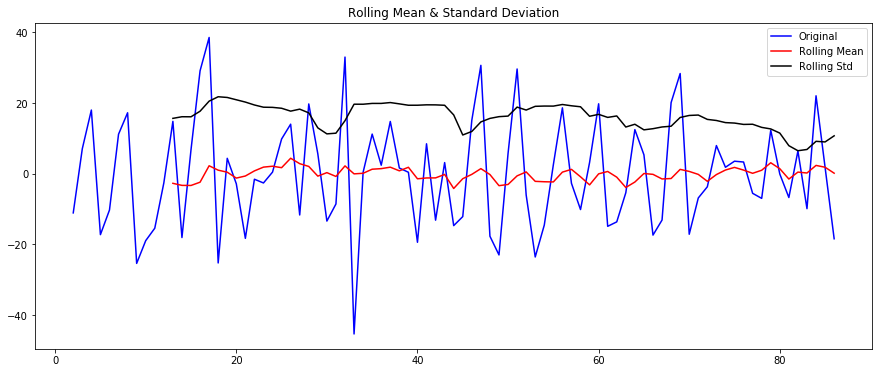

Results of Dickey-Fuller Test:
Test Statistic                 -4.928676
p-value                         0.000031
#Lags Used                      9.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [9]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller

y = no_promo_hyper.ventas_valor
z = y.diff()
z.dropna(inplace=True)

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)#On transformed data
test_stationarity(z) #one transformation is enough

## Orignial ACF PACF

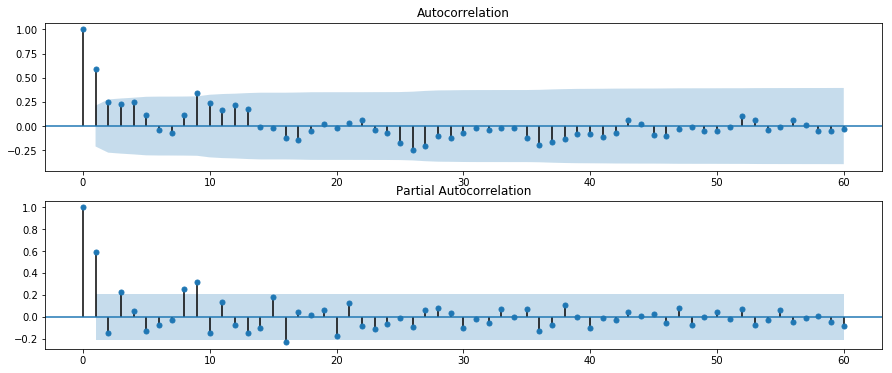

In [10]:
#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=60, ax=ax2)
plt.show()

## Differenced ACF, PACF

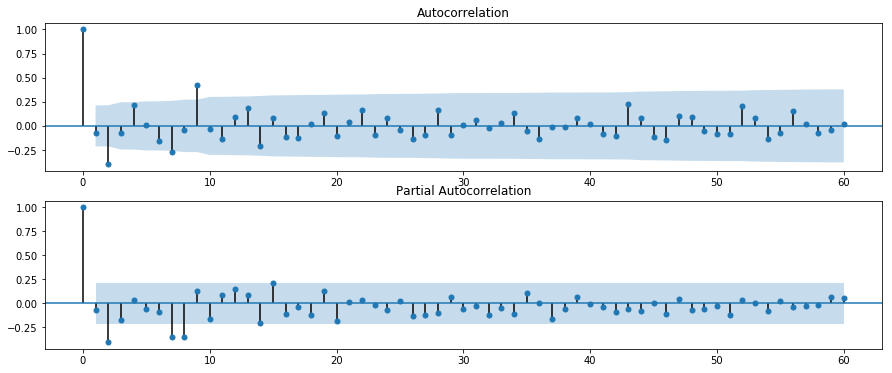

In [11]:
#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(z, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(z, lags=60, ax=ax2)
plt.show()

## Seasonal ACF, PACF

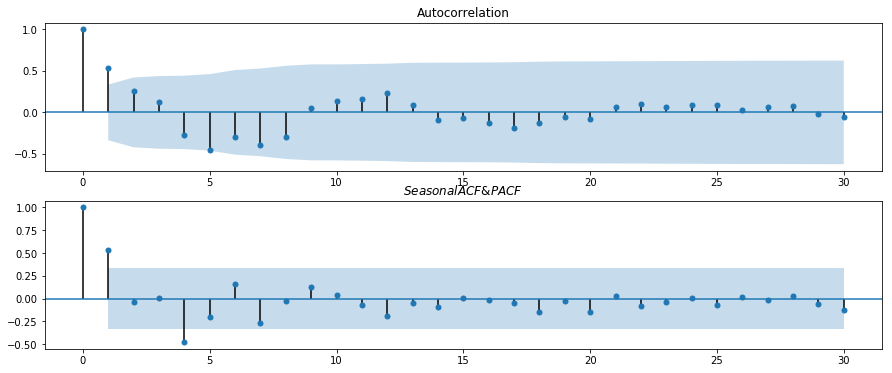

In [12]:
#TAKE THE SEASONAL DIFFERENCE
from matplotlib import pyplot

X = y.values
diff = list()
weeks_in_year = 52
for i in range(weeks_in_year, len(X)):
	value = X[i] - X[i - weeks_in_year]
	diff.append(value)
#pyplot.plot(diff)
#pyplot.show()


#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=30, ax=ax2)
plt.title('$Seasonal ACF & PACF$')
plt.show()

# HYPERMARKET
## SARIMAX 

In [13]:
#w_milk2_mhp
meta_time_period = pd.read_excel(io='Dictionary.xlsx', sheet_name='Time_Periods')
test = pd.merge(no_promo_hyper.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test = test.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test = test.dropna()

### Correlations

In [16]:
# POSITIVE CORS
test[test.columns[1:]].corr()['ventas_valor'][:-1].sort_values(ascending=False).dropna()

ventas_valor                             1.000000
sales_value_by_sqmeter                   0.996218
ventas_volumen                           0.973109
sales_volume_by_sqmeter                  0.968560
ventas_unidades                          0.932963
brnd_present_sum                         0.485363
brnd_present_OTH_MAN_BRAND_9             0.436856
sgmnt_present_FRESH                      0.404236
brnd_present_OTH_MAN_BRAND_6             0.397366
dummy_TETRA_BRICK                        0.379254
dummy_VITAMIN                            0.373874
precio_tarifa_by_precio_real             0.362212
brnd_present_OTH_MAN_BRAND_2             0.355767
sgmnt_present_OTHERS                     0.346619
dummy_3_YEARS_OLD                        0.331955
dummy_KIDS_<=_3_YEARS_OLD                0.330476
stores_on_postal_code                    0.321691
variety_present_2_YEARS_OLD              0.314253
dummy_1000ML                             0.305980
dummy_CEREALS                            0.290381


In [17]:
# NEGATIVE CORS
test[test.columns[1:]].corr()['ventas_valor'][:-1].sort_values(ascending=True).dropna()

products_present_on_store               -0.398040
dummy_BOTTLE                            -0.379254
dummy_spring                            -0.343683
addtv_present_COCOA_COFFEE              -0.333554
brnd_present_MAN_1_BRAND_2              -0.329207
addtive_present_sum                     -0.328634
dummy_COCOA_COFFEE                      -0.321183
sgmnt_present_ECOLOGIC                  -0.318026
dummy_SEMI_SKIMMED                      -0.306067
frmt_present_sum                        -0.302529
frmt_present_CRISTAL                    -0.299752
dummy_1500ML                            -0.296963
dummy_Promo_regalo                      -0.253259
dummy_KIDS_>_3_YEARS_OLD                -0.244905
prom_times_pop_dummy_Promo_regalo       -0.239655
population_post_code                    -0.233805
brnd_present_MAN_2_-BRAND_3             -0.226953
dummy_DIGESTIVE                         -0.217197
sgmnt_present_OTHER_ANIMALS_(NO_COWS)   -0.212335
cod_provincia                           -0.210647


## Promotion Effect
### NO PROMOTION WITH COMPEITION

In [18]:
#exogm2 = w_milk2_mhp[['TEMP_MEDIA', 'PRECIPITACION']].values
#endogm2 = w_milk2_mhp['ventas_valor'].values
endog1 = test['ventas_valor'] 
exog1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (7,))x(0, 1, (), 52)   Log Likelihood                -125.738
Date:                                Sun, 08 Jul 2018   AIC                            259.475
Time:                                        14:55:36   BIC                            269.293
Sample:                                    01-11-2015   HQIC                           263.426
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     0.2183      1.141     

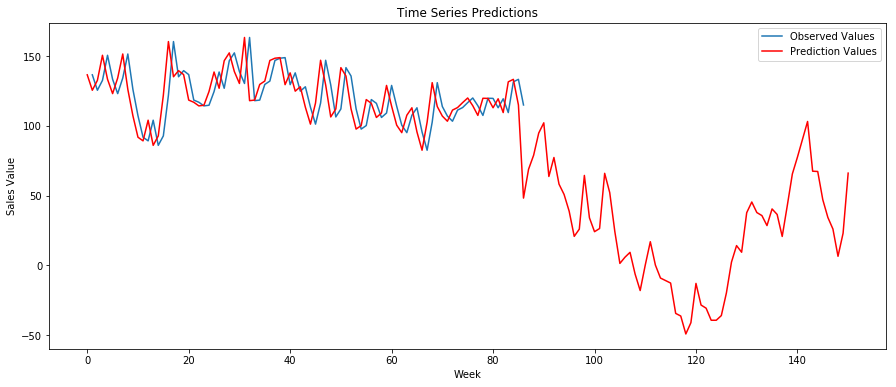

In [19]:
endog1 = test['ventas_valor'] 
exog1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

# Fit the model with fixed lags
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=test[['products_present_on_store']] ,trend='c', order=((0),1,(0,0,0,0,0,0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=exog1, typ='linear')
predi1


history1 = [x for x in endog1]
week = 1
for pred in predi1:
	#print('Week %d: %f' % (week, pred))
	history1.append(pred)
	week += 1
    

plt.plot(y)
plt.plot(history1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

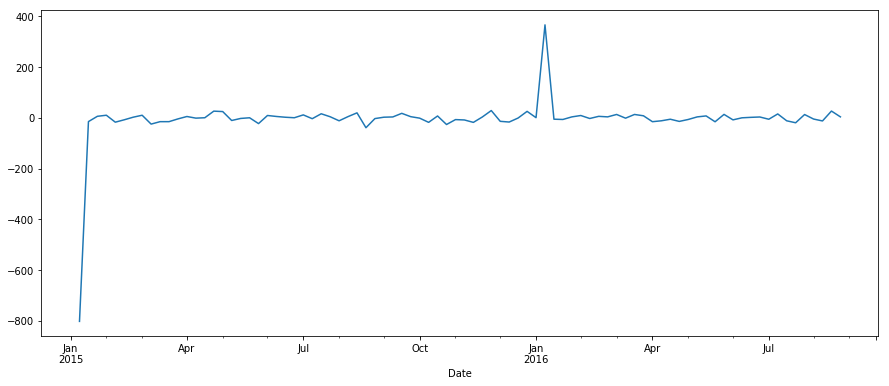

In [20]:
res.resid.plot()

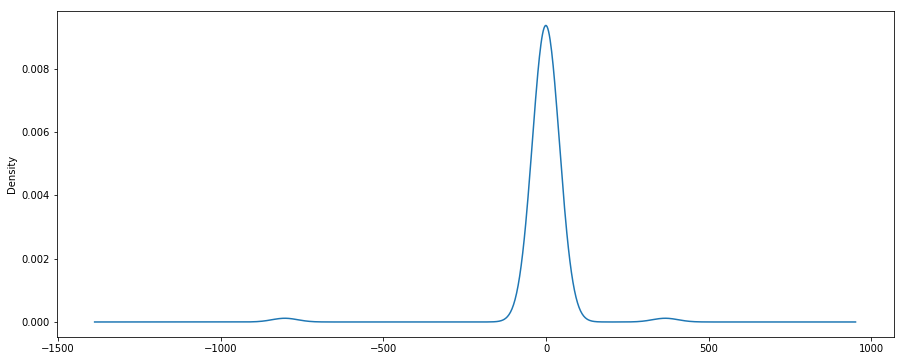

In [21]:
res.resid.plot(kind='kde')

## No Promotion WITHOUT COMPETITION

In [183]:
#exogm2 = w_milk2_mhp[['TEMP_MEDIA', 'PRECIPITACION']].values
#endogm2 = w_milk2_mhp['ventas_valor'].values
endog2 = test['ventas_valor'] 
#exog2 = test[['TEMP_MEDIA', 'products_present_on_store']][:65].values #.reshape(65, 1)
print(exog2.shape == endog2.shape)

False


                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (5,))x(0, 1, (), 52)   Log Likelihood                -132.365
Date:                                Thu, 05 Jul 2018   AIC                            270.729
Time:                                        21:36:05   BIC                            278.092
Sample:                                    01-11-2015   HQIC                           273.692
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1822      1.428      0.128      0.899      -2.617       2.981
ma.

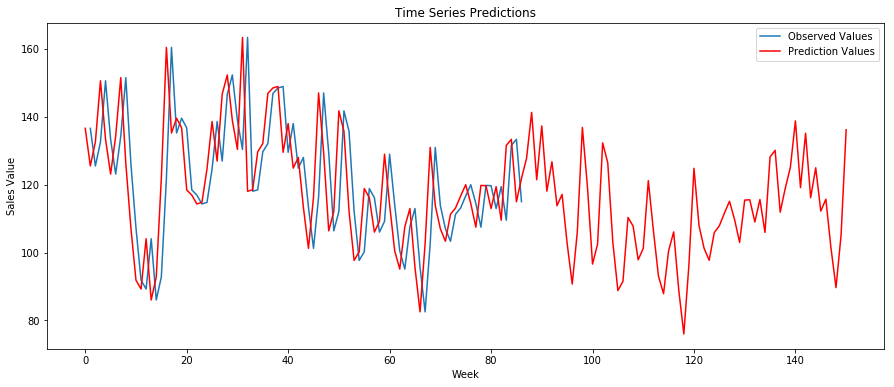

In [260]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=None ,trend='c', order=((0),1,(0,0,0,0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi2 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=None, typ='linear')
predi2

history2 = [x for x in endog2]
week = 1
for pred in predi2:
	#print('Week %d: %f' % (week, pred))
	history2.append(pred)
	week += 1
    

plt.plot(y)
plt.plot(history2, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

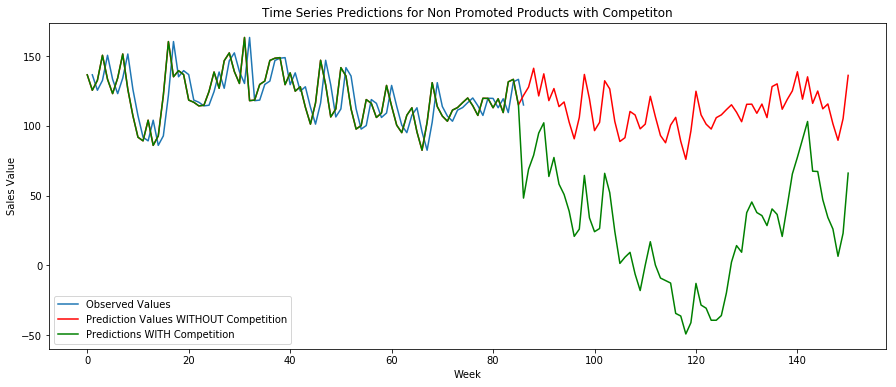

In [261]:
plt.plot(y)
plt.plot(history2, color='red')
plt.plot(history1, color='green')
plt.title('Time Series Predictions for Non Promoted Products with Competiton')
plt.legend(['Observed Values', 'Prediction Values WITHOUT Competition', 'Predictions WITH Competition'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

# HYPERMARKET - PROMO
## STEPWISE REGRESSION

In [176]:
import statsmodels.api as sm


XX = promo_hyper.drop(['ventas_valor'], axis=1)
yy = promo_hyper.ventas_valor


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(XX, yy)

print('resulting features:')
print(result)

Add  sales_value_by_sqmeter         with p-value 3.89127e-93
Add  addtv_present_OMEGA_3          with p-value 7.30376e-12
Add  addtv_present_CALCIUM          with p-value 7.30376e-12
Add  dummy_Promo_descuento          with p-value 7.30376e-12
Add  addtv_present_OTHERS           with p-value 7.30376e-12
Add  sgmnt_present_KIDS_<=_3_YEARS_OLD with p-value 7.30376e-12
Add  brnd_present_MAN_3_BRAND_1     with p-value 7.30376e-12
Add  dummy_channel_hypermarket      with p-value 7.30376e-12
Add  dummy_MANUFACTURER_2           with p-value 7.30376e-12
Add  brnd_present_MAN_2_BRAND_1     with p-value 7.30376e-12
Add  variety_present_3_YEARS_OLD    with p-value 7.30376e-12
Add  manuf_present_MANUFACTURER_2   with p-value 7.30376e-12
Add  sgmnt_present_KIDS_>_3_YEARS_OLD with p-value 7.30376e-12
Add  sgmnt_present_CARDIO           with p-value 7.30376e-12
Add  addtv_present_CEREALS          with p-value 7.30376e-12
Add  sales_surface_sqmeters         with p-value 1.64192e-11
Add  dummy_autum   

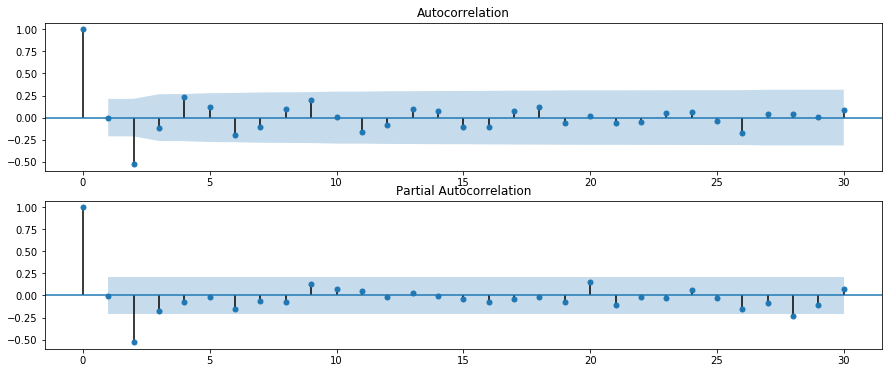

In [262]:
#GET PARAMETERS FOR P,D,Q

zz = yy.diff()
zz.dropna(inplace=True)

#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(zz, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(zz, lags=30, ax=ax2)
plt.show()

In [263]:
#w_milk2_mhp
meta_time_period = pd.read_excel(io='Dictionary.xlsx', sheet_name='Time_Periods')
test1 = pd.merge(promo_hyper.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test1 = test1.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test1 = test1.dropna()

In [264]:
#exogm2 = w_milk2_mhp[['TEMP_MEDIA', 'PRECIPITACION']].values
#endogm2 = w_milk2_mhp['ventas_valor'].values
endogs1 = test1['ventas_valor'] 
exogs1 = test1[['products_present_on_store']][:65].values #.reshape(65, 1)

In [358]:
test1[test1.columns[1:]].corr()['ventas_valor'][:-1].sort_values(ascending=True, na=False)

dummy_spring                                -0.587155
brnd_present_OTH_MAN_BRAND_2                -0.477610
dummy_BOTTLE                                -0.407209
dummy_Promo_regalo                          -0.399439
frmt_present_CRISTAL                        -0.388495
frmt_present_sum                            -0.369741
dummy_1500ML                                -0.355002
prom_times_pop_dummy_Promo_regalo           -0.340863
dummy_CLASSIC                               -0.340002
dummy_SEMI_SKIMMED                          -0.321769
dummy_COCOA_COFFEE                          -0.268269
addtv_present_COCOA_COFFEE                  -0.255959
dummy_MAN_2_-BRAND_3                        -0.239930
stores_on_postal_code                       -0.236743
brnd_present_OTH_MAN_BRAND_4                -0.230649
brnd_present_MAN_2_-BRAND_3                 -0.221458
dummy_200ML                                 -0.219474
dummy_Promo_extra_cantidad                  -0.217783
sales_surface_sqmeters      

## Promo + COMPETITON

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -151.337
Date:                                Thu, 05 Jul 2018   AIC                            310.675
Time:                                        21:37:36   BIC                            320.492
Sample:                                    01-11-2015   HQIC                           314.626
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     1.9139      2.468     

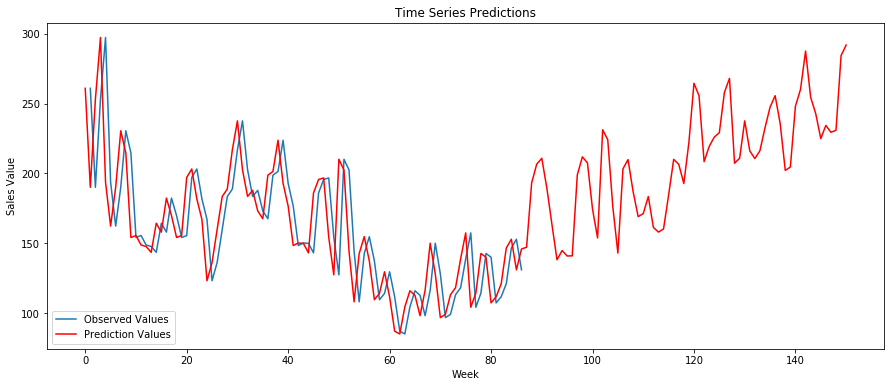

In [267]:
# Fit the model
endogs1 = test1['ventas_valor'] 
exogs1 = test1[['products_present_on_store']][:65].values #.reshape(65, 1)

mod = sm.tsa.statespace.SARIMAX(endog= test1['ventas_valor'] , exog=test1[['products_present_on_store']] ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis1 = res.predict(start=86, end=150, endog= test1['ventas_valor'].values ,exog=exogs1, typ='linear')
predis1

historys1 = [x for x in endogs1]
week = 1
for pred in predis1:
	#print('Week %d: %f' % (week, pred))
	historys1.append(pred)
	week += 1
    

plt.plot(yy)
plt.plot(historys1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## PROMO + NO Competition

In [77]:
endogs2 = test1['ventas_valor'] 
#exogs2 = test1[['TEMP_MEDIA', 'brnd_present_MAN_2_BRAND_1']][:65].values #.reshape(65, 1)

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -154.216
Date:                                Thu, 05 Jul 2018   AIC                            314.433
Time:                                        21:37:59   BIC                            321.796
Sample:                                    01-11-2015   HQIC                           317.396
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4576      2.761      0.528      0.598      -3.954       6.869
ma.

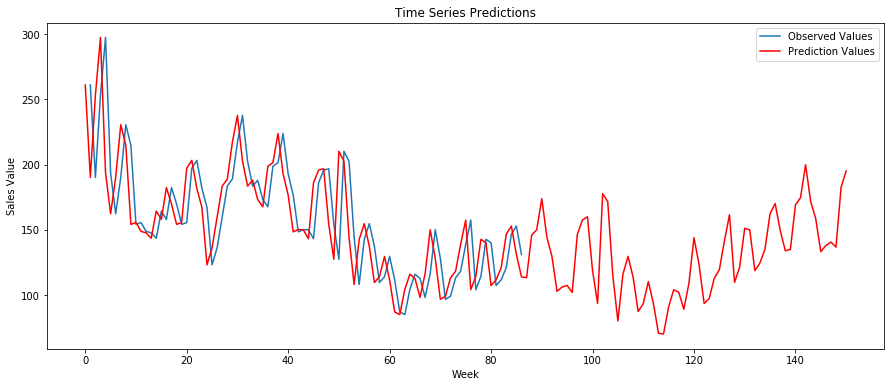

In [269]:
# Fit the model

mod = sm.tsa.statespace.SARIMAX(endog= test1['ventas_valor'] , exog=None ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis2 = res.predict(start=86, end=150, endog= test1['ventas_valor'].values ,exog=None, typ='linear')
predis2

historys2 = [x for x in endogs2]
week = 1
for pred in predis2:
	#print('Week %d: %f' % (week, pred))
	historys2.append(pred)
	week += 1
    

plt.plot(yy)
plt.plot(historys2, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

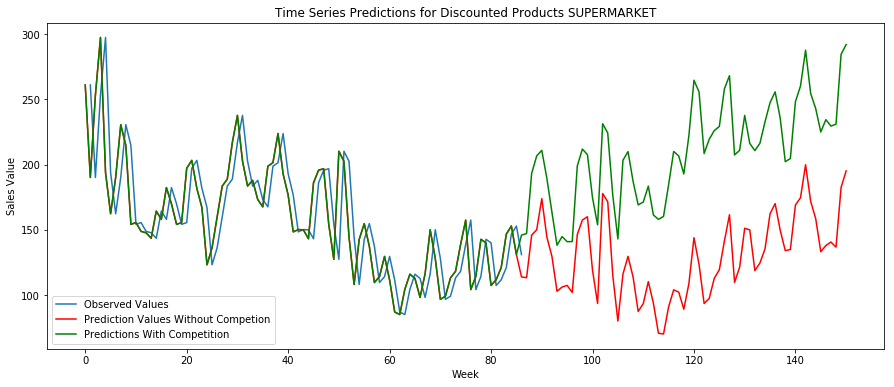

In [270]:
plt.plot(yy)
plt.plot(historys2, color='red')
plt.plot(historys1, color='green')
plt.title('Time Series Predictions for Discounted Products SUPERMARKET')
plt.legend(['Observed Values', 'Prediction Values Without Competion', 'Predictions With Competition'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

predicted=132.956533, expected=98.301648
predicted=90.634011, expected=116.497925
predicted=156.291944, expected=150.144309
predicted=127.836311, expected=128.209677
predicted=107.534899, expected=96.868576
predicted=102.874228, expected=99.215886
predicted=148.032658, expected=113.250000
predicted=119.386967, expected=118.309133
predicted=108.699144, expected=138.916620
predicted=127.589877, expected=157.510133
predicted=92.524216, expected=104.292654
predicted=96.564254, expected=114.424242
predicted=138.694585, expected=142.800546
predicted=166.670459, expected=140.096517
predicted=141.050773, expected=107.438023
predicted=147.326321, expected=111.832428
predicted=155.087319, expected=121.122774
predicted=97.938859, expected=146.670352
predicted=140.364137, expected=152.961394
predicted=139.671533, expected=131.088068
Test MSE: 619.258


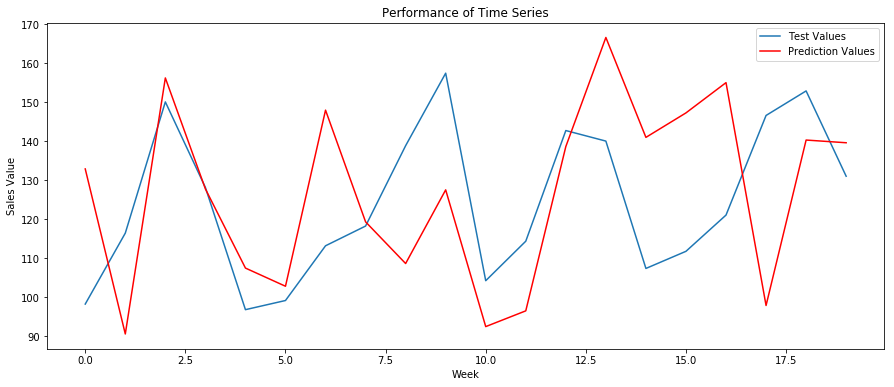

In [295]:
#https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


series = test1['ventas_valor']
X = series.values
size = int(len(X) * 0.77) #split into 2/3 train 1/3 test
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = sm.tsa.statespace.SARIMAX(history, exog= None, order=((0,1),1,(0,0,1)), seasonal_order=(0,1,0,52)) #reduced the MSE but does not account for stationarity
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
plt.title('Performance of Time Series')
plt.legend(['Test Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

In [296]:
mse = sum(abs(test-predictions))/sum(test)
#print(mse)
mse.mean()

0.16492470624380895

In [279]:
target = milk_weekly.ventas_valor

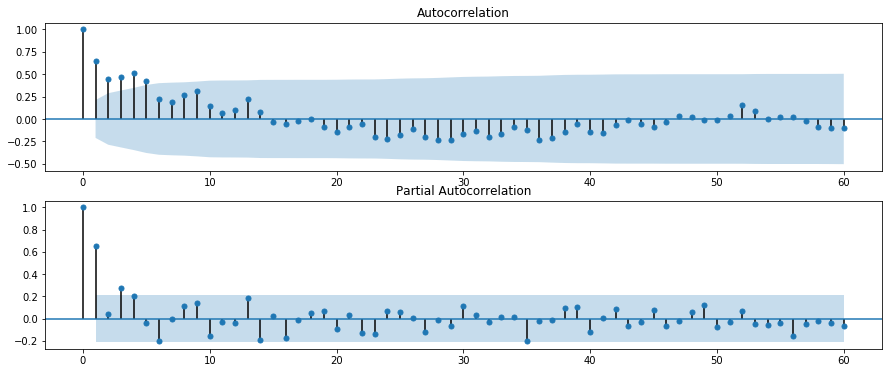

In [280]:
#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(target, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(target, lags=60, ax=ax2)
plt.show()

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -94.468
Date:                            Thu, 05 Jul 2018   AIC                            194.935
Time:                                    22:24:30   BIC                            202.298
Sample:                                         0   HQIC                           197.898
                                             - 86                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7124      0.774      0.921      0.357      -0.804       2.229
ar.L1         -0.6421      0.146   

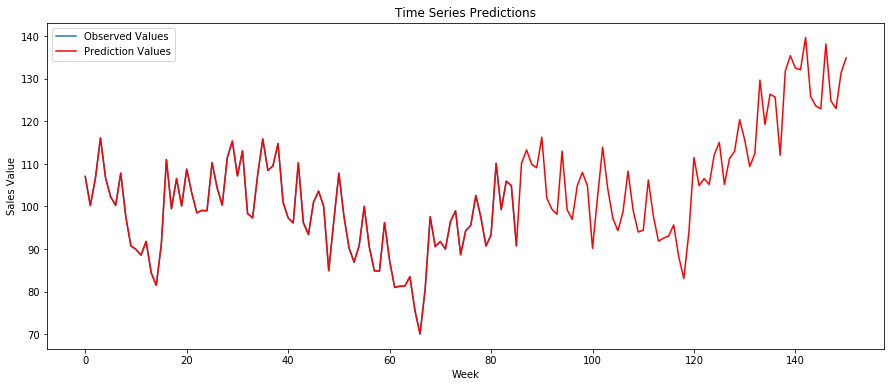

In [315]:
# Fit the model
target = milk_weekly.ventas_valor.values
mod = sm.tsa.statespace.SARIMAX(target, trend='c', order=(1,1,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi = res.predict(start=86, end=150, exog=None, dynamic=False)
predi

history = [x for x in target]
week = 1
for pred in predi:
	#print('Week %d: %f' % (week, pred))
	history.append(pred)
	week += 1
    

plt.plot(target)
plt.plot(history, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -94.468
Date:                            Thu, 05 Jul 2018   AIC                            194.935
Time:                                    22:27:13   BIC                            202.298
Sample:                                         0   HQIC                           197.898
                                             - 86                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7124      0.774      0.921      0.357      -0.804       2.229
ar.L1         -0.6421      0.146   

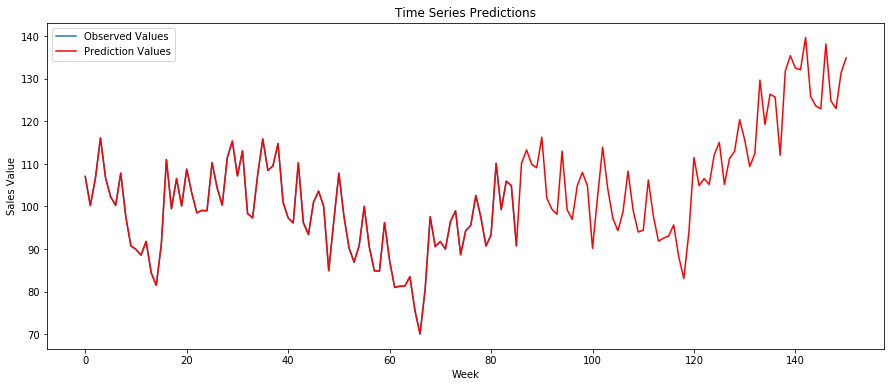

In [319]:
# Fit the model
target = milk_weekly.ventas_valor.values
mod = sm.tsa.statespace.SARIMAX(target, trend='c', order=(1,1,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi = res.predict(start=86, end=150, exog=None, dynamic=False)
predi

history = [x for x in target]
week = 1
for pred in predi:
	#print('Week %d: %f' % (week, pred))
	history.append(pred)
	week += 1
    

plt.plot(target)
plt.plot(history, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## SARMIMAX ON PROMOTION ISOLATED / NON ISOLATE

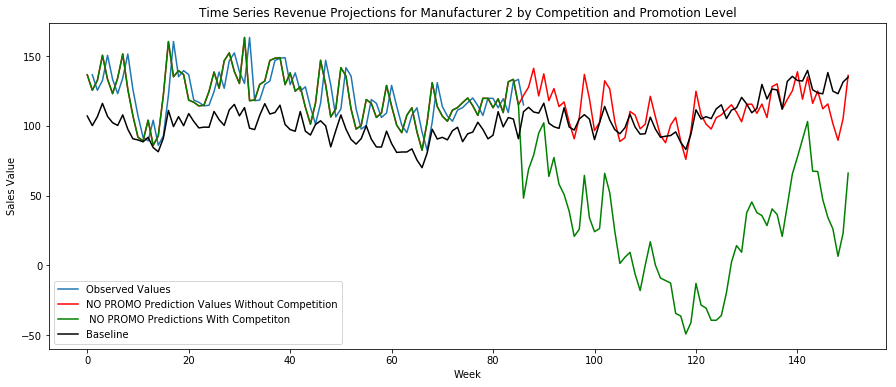

In [320]:
plt.plot(y)
plt.plot(history2, color='red')
plt.plot(history1, color='green')
#plt.plot(historys2, color='pink')
#plt.plot(historys1, color='violet')
plt.plot(history, color='black')
plt.title('Time Series Revenue Projections for Manufacturer 2 by Competition and Promotion Level')
plt.legend(['Observed Values', 'NO PROMO Prediction Values Without Competition', ' NO PROMO Predictions With Competiton', 'Baseline'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
plt.savefig('Time_Series_Manu1.png', dpi=700)
pyplot.show()

## SUPERMARKET

In [325]:
#NO PROMOTIONS
milk2_msnp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']!=1) & (milk['dummy_Promo_descuento']!=1)]
no_promo_super = milk2_msnp.groupby('cod_semana').mean()


#PROMOTIONS
milk2_msp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']!=1) & (milk['dummy_Promo_descuento']==1)]
promo_super = milk2_msp.groupby('cod_semana').mean()

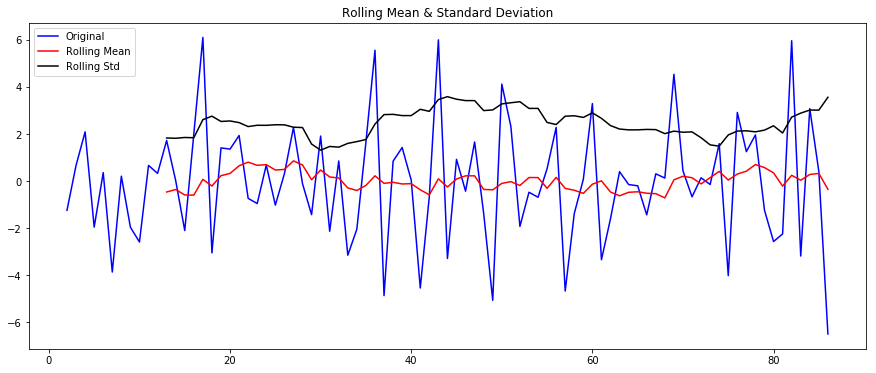

Results of Dickey-Fuller Test:
Test Statistic                -7.462783e+00
p-value                        5.299810e-11
#Lags Used                     2.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


In [327]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller

y = no_promo_super.ventas_valor
z = y.diff()
z.dropna(inplace=True)

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)#On transformed data
test_stationarity(z) #one transformation is enough

## Differenced PACF ACF

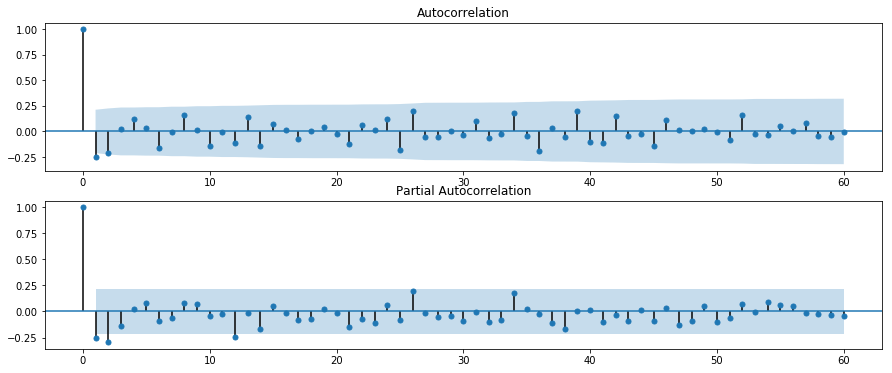

In [328]:
#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(z, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(z, lags=60, ax=ax2)
plt.show()

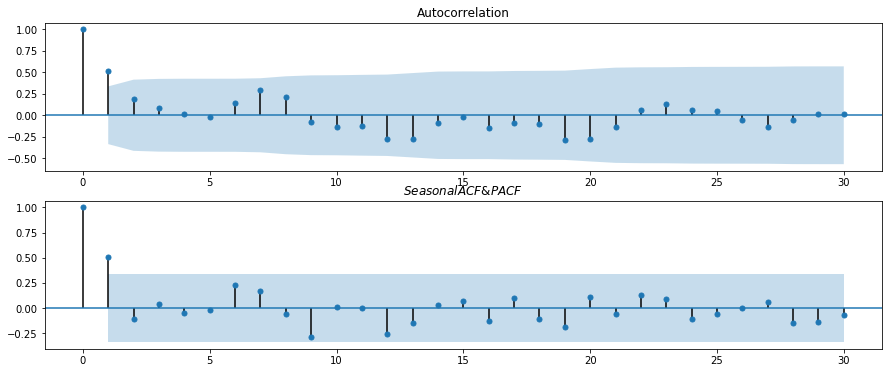

In [329]:
#TAKE THE SEASONAL DIFFERENCE
from matplotlib import pyplot

X = y.values
diff = list()
weeks_in_year = 52
for i in range(weeks_in_year, len(X)):
	value = X[i] - X[i - weeks_in_year]
	diff.append(value)
#pyplot.plot(diff)
#pyplot.show()


#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=30, ax=ax2)
plt.title('$Seasonal ACF & PACF$')
plt.show()

In [332]:
meta_time_period = pd.read_excel(io='Dictionary.xlsx', sheet_name='Time_Periods')
test = pd.merge(no_promo_super.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test = test.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test = test1.dropna()

#Exo + Endo
endogs1 = test['ventas_valor'] 
exogs1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

## NO PROMOTIONS + COMPETITION

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX((2,), 1, 0)x((), 1, 0, 52)   Log Likelihood                -151.067
Date:                                Thu, 05 Jul 2018   AIC                            310.134
Time:                                        22:46:56   BIC                            319.951
Sample:                                    01-11-2015   HQIC                           314.085
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     3.5342      4.645     

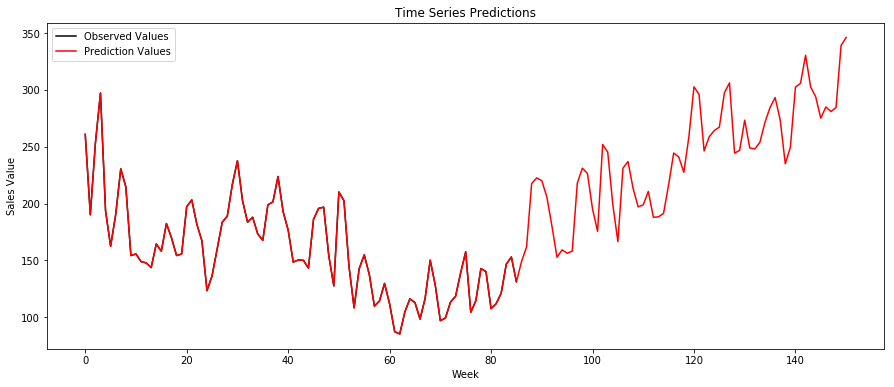

In [343]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=test[['products_present_on_store']] ,trend='c', order=((0,1),1,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values, exog=exogs1, typ='linear')
predis1

historys1 = [x for x in endogs1]
week = 1
for pred in predis1:
	#print('Week %d: %f' % (week, pred))
	historys1.append(pred)
	week += 1
    

plt.plot(test['ventas_valor'].values, color='black')
plt.plot(historys1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## NO PROMOTIONS + NO COMPETITION

                                 Statespace Model Results                                 
Dep. Variable:                       ventas_valor   No. Observations:                   86
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -159.286
Date:                            Thu, 05 Jul 2018   AIC                            324.573
Time:                                    22:51:20   BIC                            331.936
Sample:                                01-11-2015   HQIC                           327.536
                                     - 08-28-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -25.7510     11.471     -2.245      0.025     -48.234      -3.268
ar.L1          0.6050      0.131   

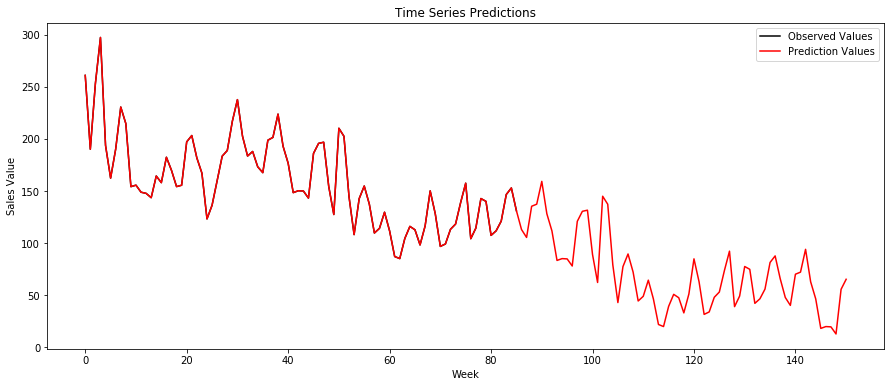

In [354]:
# Fit the model
endogs2 = test['ventas_valor'] 

mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=None ,trend='c', order=((1),0,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis2 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=None, typ='linear')
predis2

historys2 = [x for x in endogs2]
week = 1
for pred in predis2:
	#print('Week %d: %f' % (week, pred))
	historys2.append(pred)
	week += 1
    

plt.plot(test['ventas_valor'].values, color='black')
plt.plot(historys2, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## PROMOTIONS + COMPETITON

In [355]:
meta_time_period = pd.read_excel(io='Dictionary.xlsx', sheet_name='Time_Periods')
test = pd.merge(promo_super.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test = test.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test = test1.dropna()

#Exo + Endo
endog1 = test['ventas_valor'] 
exog1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -151.337
Date:                                Thu, 05 Jul 2018   AIC                            310.675
Time:                                        22:57:34   BIC                            320.492
Sample:                                    01-11-2015   HQIC                           314.626
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     1.9139      2.468     

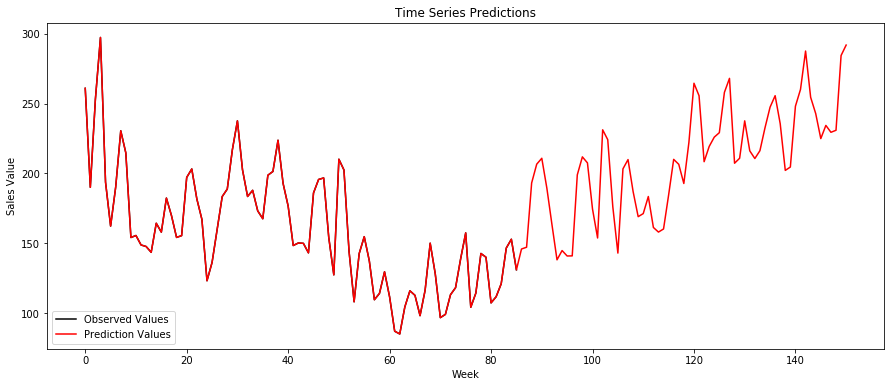

In [365]:
endog1 = test['ventas_valor'] 
exog1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

# Fit the model with fixed lags
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=test[['products_present_on_store']] ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=exog1, typ='linear')
predi1


history1 = [x for x in endog1]
week = 1
for pred in predi1:
	#print('Week %d: %f' % (week, pred))
	history1.append(pred)
	week += 1
    

plt.plot(test.ventas_valor.values, color='black')
plt.plot(history1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -154.216
Date:                                Thu, 05 Jul 2018   AIC                            314.433
Time:                                        23:01:41   BIC                            321.796
Sample:                                    01-11-2015   HQIC                           317.396
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4576      2.761      0.528      0.598      -3.954       6.869
ma.

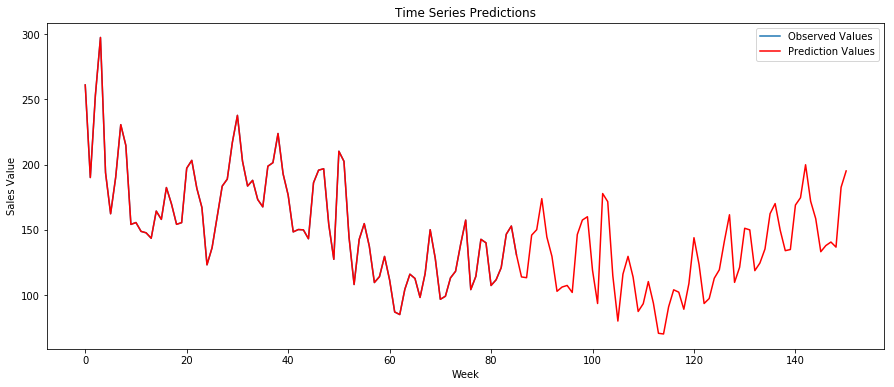

In [372]:
# Fit the model
endogs1 = test['ventas_valor'] 
#exogs1 = test1[['products_present_on_store']][:65].values #.reshape(65, 1)

mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=None ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=None, typ='linear')
predis1

historys1 = [x for x in endogs1]
week = 1
for pred in predis1:
	#print('Week %d: %f' % (week, pred))
	historys1.append(pred)
	week += 1
    

plt.plot(test.ventas_valor.values)
plt.plot(historys1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## Baseline

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -94.468
Date:                            Thu, 05 Jul 2018   AIC                            194.935
Time:                                    23:04:39   BIC                            202.298
Sample:                                         0   HQIC                           197.898
                                             - 86                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7124      0.774      0.921      0.357      -0.804       2.229
ar.L1         -0.6421      0.146   

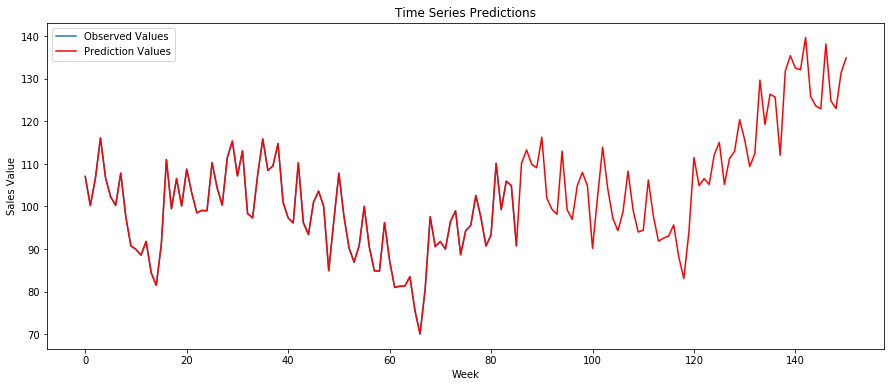

In [380]:
# Fit the model
target = milk_weekly.ventas_valor.values
mod = sm.tsa.statespace.SARIMAX(target, trend='c', order=(1,1,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi = res.predict(start=86, end=150, exog=None, dynamic=False)
predi

history = [x for x in target]
week = 1
for pred in predi:
	#print('Week %d: %f' % (week, pred))
	history.append(pred)
	week += 1
    

plt.plot(target)
plt.plot(history, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

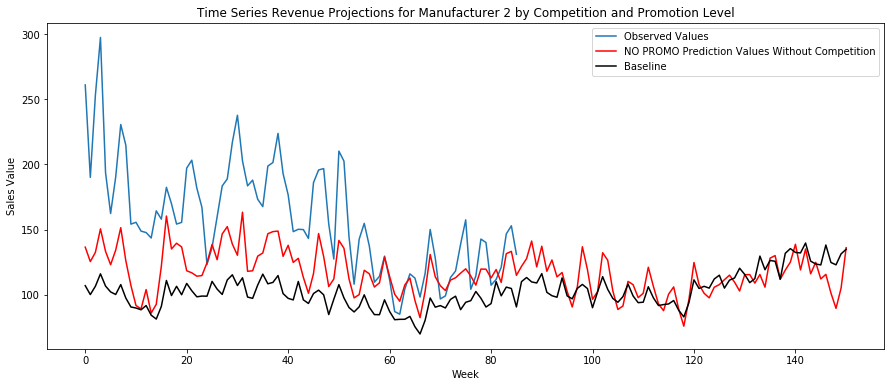

In [384]:
plt.plot(test1.ventas_valor.values)
plt.plot(history2, color='red')
#plt.plot(history1, color='green')
#plt.plot(historys2, color='pink')
#plt.plot(historys1, color='violet')
plt.plot(history, color='black')
plt.title('Time Series Revenue Projections for Manufacturer 2 by Competition and Promotion Level')
plt.legend(['Observed Values', 'NO PROMO Prediction Values Without Competition', 'Baseline'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
plt.savefig('Time_Series_Manu1_Supermarket.png', dpi=700)
pyplot.show()